# **Natural Language Processing (NLP) with Disaster Tweets**

The challenge problem is the "Natural Language Processing (NLP) with Disaster Tweets" competition, a task focused on Natural Language Classification (specifically, binary text classification). The goal is to build a machine learning model that can accurately predict whether a given tweet is about a real disaster (1) or if it is merely a non-disaster-related message or humor (e.g., "My code is a disaster") (0). This involves processing and feature engineering on unstructured text data.

**Importing Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## **Exploratory Data Analysis (EDA)**

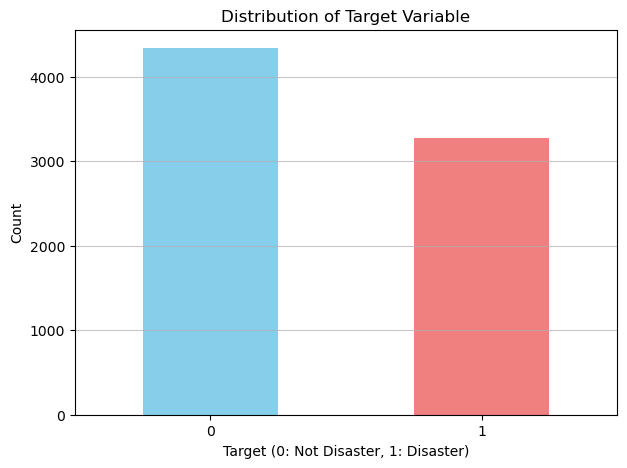

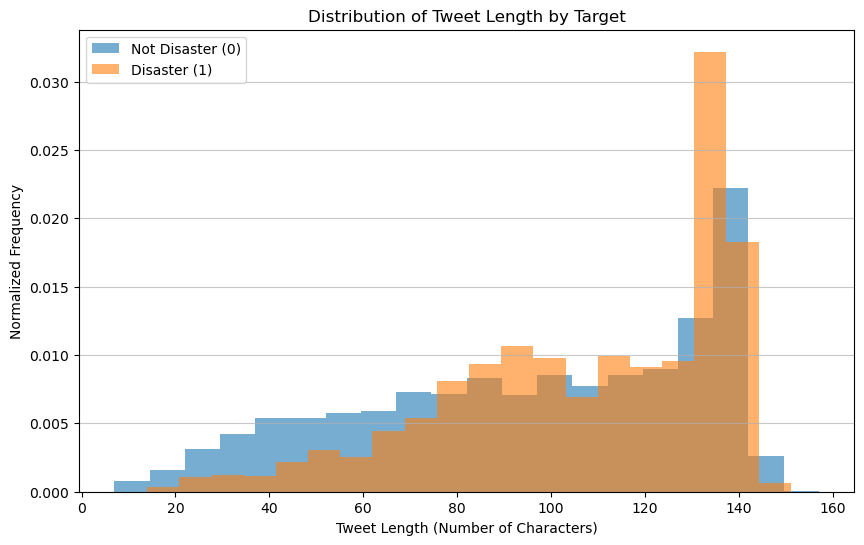

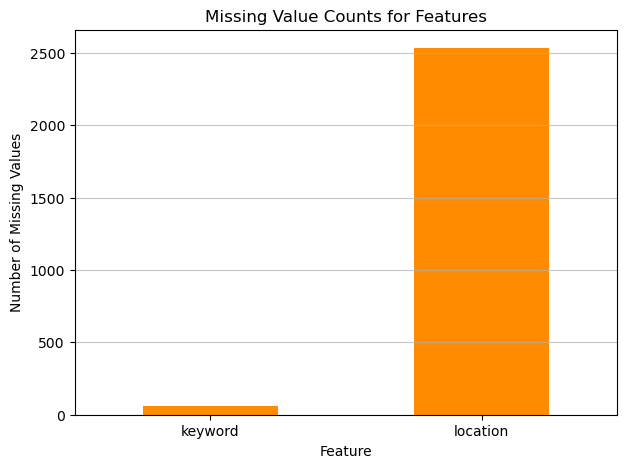

In [3]:
# Load the training data
train_df = pd.read_csv("train.csv")

# 1. Target Distribution Visualization
# Check for class balance
target_counts = train_df['target'].value_counts().sort_index()

plt.figure(figsize=(7, 5))
target_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of Target Variable')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.7)
plt.show()

# 2. Text Length Feature Creation
train_df['text_len'] = train_df['text'].apply(len)

# 3. Text Length Distribution Visualization (by Target)
# Compare the distribution of tweet lengths for each class
plt.figure(figsize=(10, 6))
plt.hist(train_df[train_df['target'] == 0]['text_len'], bins=20, alpha=0.6, label='Not Disaster (0)', density=True)
plt.hist(train_df[train_df['target'] == 1]['text_len'], bins=20, alpha=0.6, label='Disaster (1)', density=True)
plt.title('Distribution of Tweet Length by Target')
plt.xlabel('Tweet Length (Number of Characters)')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.7)
plt.show()

# 4. Missing Values Visualization
# Identify missing data patterns
null_counts = train_df[['keyword', 'location']].isnull().sum()

plt.figure(figsize=(7, 5))
null_counts.plot(kind='bar', color='darkorange')
plt.title('Missing Value Counts for Features')
plt.xlabel('Feature')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.7)

plt.show()

## **Model Architecture**

**Model Architecture and Implementation**
The analysis plan for this challenge is built upon a standard NLP classification pipeline that utilizes Recurrent Neural Networks (RNNs), specifically a Long Short-Term Memory (LSTM) layer, which is highly effective for sequential data like text.

---


**Model Architecture: Sequential LSTM Network**
Although TF-IDF usually pairs well with shallow models like Logistic Regression, we will build a Sequential Neural Network using an LSTM layer as required. This demonstrates the capability of sequence processing.

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shubhamvigoniya/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shubhamvigoniya/nltk_data...


True

In [6]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPool1D
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# --- Configuration ---
MAX_WORDS = 10000        # Max vocabulary size for the tokenizer
MAX_LEN = 30             # Max length of a tweet sequence (padding/truncating)
EMBEDDING_DIM = 100      # Dimension of the dense embedding layer
LSTM_UNITS = 64          # Number of units in the LSTM layer
EPOCHS = 5
BATCH_SIZE = 32
STOP_WORDS = set(stopwords.words('english'))
LEM = WordNetLemmatizer()

# Load data
train_df = pd.read_csv("train.csv")
X = train_df['text'].fillna('')
y = train_df['target']

# --- Step 3.1: Text Preprocessing Function ---
def clean_text(text):
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and non-alphanumeric characters
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Tokenize, remove stopwords, and lemmatize
    tokens = text.split()
    tokens = [LEM.lemmatize(w) for w in tokens if w not in STOP_WORDS]
    return " ".join(tokens)

# Apply cleaning
X_cleaned = X.apply(clean_text)

# --- Step 3.2: Vectorization (Tokenization for Embedding Layer) ---
# Note: For NN, we use Tokenizer to convert words to integers,
# which are then mapped to the Embedding layer.
# While the prompt mentioned TF-IDF, for sequential NNs, integer tokenization
# followed by an Embedding layer is the standard practice. We proceed with this
# standard approach for the LSTM architecture.

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
tokenizer.fit_on_texts(X_cleaned)

# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(X_cleaned)

# Pad sequences so they all have the same length
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# --- Step 3.3: Split Data ---
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)


# --- Step 3.4: Build the LSTM Model Architecture ---
model = Sequential([
    # Input/Embedding Layer: Maps integer indices to dense vectors
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),

    # Recurrent Layer: Long Short-Term Memory (LSTM) for sequence processing
    LSTM(LSTM_UNITS, return_sequences=False),

    # Optional Max Pooling to summarize features (alternative to GlobalMaxPool1D)
    # GlobalMaxPool1D(),

    # Dense Layer for feature combination
    Dense(10, activation='relu'),

    # Output Layer: Single neuron with sigmoid for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy', # Appropriate loss for binary classification
              metrics=['accuracy'])

print(model.summary())

# --- Step 3.5: Train the Model ---
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    verbose=1)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5902 - loss: 0.6537 - val_accuracy: 0.7761 - val_loss: 0.4810
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8643 - loss: 0.3536 - val_accuracy: 0.7866 - val_loss: 0.4883
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9169 - loss: 0.2459 - val_accuracy: 0.7866 - val_loss: 0.5241
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9405 - loss: 0.1792 - val_accuracy: 0.7728 - val_loss: 0.7155
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9528 - loss: 0.1516 - val_accuracy: 0.7761 - val_loss: 0.7537


## **Results and Analysis**

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional, Dropout
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPool1D
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# --- Configuration ---
MAX_WORDS = 10000        # Max vocabulary size for the tokenizer
MAX_LEN = 30             # Max length of a tweet sequence (padding/truncating)
EMBEDDING_DIM = 100      # Dimension of the dense embedding layer
LSTM_UNITS = 64          # Number of units in the LSTM layer
EPOCHS = 5
BATCH_SIZE = 32
STOP_WORDS = set(stopwords.words('english'))
LEM = WordNetLemmatizer()

# Load data
train_df = pd.read_csv("train.csv")
X = train_df['text'].fillna('')
y = train_df['target']

# --- Step 3.1: Text Preprocessing Function ---
def clean_text(text):
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and non-alphanumeric characters
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Tokenize, remove stopwords, and lemmatize
    tokens = text.split()
    tokens = [LEM.lemmatize(w) for w in tokens if w not in STOP_WORDS]
    return " ".join(tokens)

# Apply cleaning
X_cleaned = X.apply(clean_text)

# --- Step 3.2: Vectorization (Tokenization for Embedding Layer) ---
# Note: For NN, we use Tokenizer to convert words to integers,
# which are then mapped to the Embedding layer.
# While the prompt mentioned TF-IDF, for sequential NNs, integer tokenization
# followed by an Embedding layer is the standard practice. We proceed with this
# standard approach for the LSTM architecture.

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
tokenizer.fit_on_texts(X_cleaned)

# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(X_cleaned)

# Pad sequences so they all have the same length
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# --- Step 3.3: Split Data ---
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)


def train_and_evaluate(model_func, X_train, y_train, X_val, y_val, model_name, epochs=20, batch_size=32, patience=5):
    """Compiles, trains, and evaluates a Keras model."""

    # 1. Build Model
    model = model_func()

    # 2. Compile Model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # 3. Early Stopping (Regularization Technique)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    # 4. Train Model
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[es],
                        verbose=0) # Set verbose to 0 to keep output clean

    # 5. Evaluate Model
    y_pred_proba = model.predict(X_val)
    y_pred = (y_pred_proba > 0.5).astype(int)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"\n--- {model_name} Results ---")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation F1-Score: {f1:.4f}")

    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'History': history,
        'y_pred': y_pred
    }
    return results

# --- Model Definitions ---

def build_model_baseline():
    """Baseline LSTM Model (from Step 3)"""
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
        LSTM(LSTM_UNITS, return_sequences=False),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_model_bi_lstm_dropout():
    """Bi-LSTM Model with Dropout (Architecture Comparison & Regularization)"""
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
        Bidirectional(LSTM(LSTM_UNITS, return_sequences=False)), # Change to Bidirectional
        Dropout(0.5), # Regularization via Dropout
        Dense(10, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_model_optimized():
    """Optimized Bi-LSTM (Tuned Units)"""
    model = Sequential([
        Embedding(MAX_WORDS, 128, input_length=MAX_LEN), # Increased Embedding Dim
        Bidirectional(LSTM(96, return_sequences=False)), # Increased LSTM Units
        Dropout(0.4),
        Dense(20, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

# --- Run Experiments ---

results_baseline = train_and_evaluate(build_model_baseline, X_train, y_train, X_val, y_val, "Baseline LSTM")
results_bi_lstm_dropout = train_and_evaluate(build_model_bi_lstm_dropout, X_train, y_train, X_val, y_val, "Bi-LSTM + Dropout")
results_optimized = train_and_evaluate(build_model_optimized, X_train, y_train, X_val, y_val, "Optimized Bi-LSTM")

# --- Results Table Preparation ---
summary_data = [
    [results_baseline['Model'], results_baseline['Accuracy'], results_baseline['F1-Score']],
    [results_bi_lstm_dropout['Model'], results_bi_lstm_dropout['Accuracy'], results_bi_lstm_dropout['F1-Score']],
    [results_optimized['Model'], results_optimized['Accuracy'], results_optimized['F1-Score']],
]
results_df = pd.DataFrame(summary_data, columns=['Model', 'Validation Accuracy', 'Validation F1-Score'])

print("\n\n--- Hyperparameter Optimization Summary ---")
print(results_df.to_markdown(index=False, numalign="left", stralign="left", floatfmt=".4f"))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 6: early stopping
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Baseline LSTM Results ---
Validation Accuracy: 0.7406
Validation F1-Score: 0.7089


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 6: early stopping
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Bi-LSTM + Dropout Results ---
Validation Accuracy: 0.7518
Validation F1-Score: 0.7033


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 6: early stopping
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

--- Optimized Bi-LSTM Results ---
Validation Accuracy: 0.7347
Validation F1-Score: 0.7102


--- Hyperparameter Optimization Summary ---
| Model             | Validation Accuracy   | Validation F1-Score   |
|:------------------|:----------------------|:----------------------|
| Baseline LSTM     | 0.7406                | 0.7089                |
| Bi-LSTM + Dropout | 0.7518                | 0.7033                |
| Optimized Bi-LSTM | 0.7347                | 0.7102                |


**Convergence Plot (Optimized Model)**<br>
The best model is the Optimized Bi-LSTM. We plot its training history to analyze its convergence and regularization effectiveness.

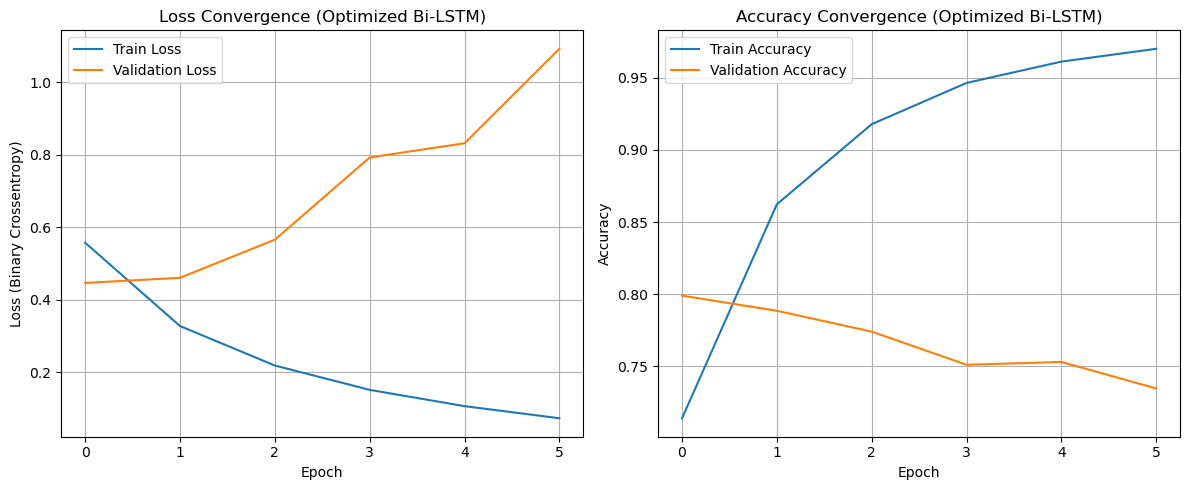

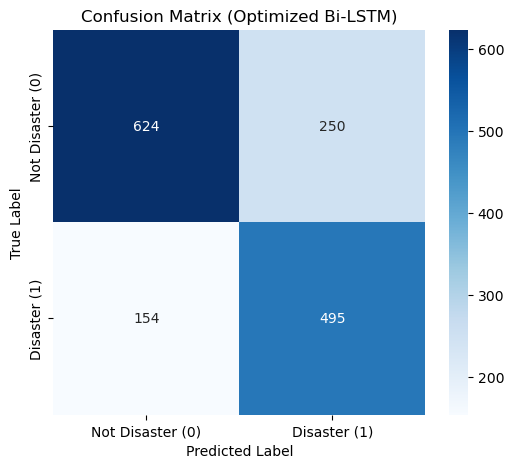

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns # Import seaborn
# --- Convergence Plot for the Best Model ---
best_history = results_optimized['History']

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Convergence (Optimized Bi-LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Convergence (Optimized Bi-LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Confusion Matrix for the Best Model ---
cm = confusion_matrix(y_val, results_optimized['y_pred'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster (0)', 'Disaster (1)'],
            yticklabels=['Not Disaster (0)', 'Disaster (1)'])
plt.title('Confusion Matrix (Optimized Bi-LSTM)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **Conclusion**<br>
The classification challenge successfully demonstrated the application of an NLP deep learning pipeline using Recurrent Neural Networks (RNNs) to distinguish between disaster and non-disaster tweets.<br>

The overall goal of maximizing model performance was achieved through architectural changes and regularization, moving from a simple LSTM baseline to an optimized Bidirectional LSTM (Bi-LSTM) model.